# Adversarial Attacks on ResNet-34 (ImageNet-1K)

In [4]:
#Importing libraries
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import json
from PIL import Image
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 187MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/TestDataSet'

Mounted at /content/drive


In [6]:
# Normalization values for ImageNet
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

# Define transform
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Load dataset
dataset_path = "/content/drive/MyDrive/TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path,
                transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


In [7]:
# Load the ImageNet class index map from labels_list.json
with open('/content/drive/MyDrive/TestDataSet/labels_list.json') as f:
    label_map = json.load(f)

In [8]:
# Map dataset class indices (0–99) to actual ImageNet class indices (401–500)
imagenet_indices = [int(entry.split(':')[0]) for entry in label_map]
class_idx_map = {i: imagenet_indices[i] for i in range(len(imagenet_indices))}

In [9]:
# Evaluate top-1 and top-5 accuracy
def evaluate_model(model, dataloader, class_idx_map):
    top1_correct = 0
    top5_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.cpu().numpy()
            mapped_labels = torch.tensor([class_idx_map[label] for label in labels], dtype=torch.long).to(device)

            outputs = model(images)
            _, pred_top1 = outputs.max(1)
            _, pred_top5 = outputs.topk(5, dim=1)

            top1_correct += (pred_top1 == mapped_labels).sum().item()
            top5_correct += sum([mapped_labels[i].item() in pred_top5[i] for i in range(len(mapped_labels))])
            total += images.size(0)
    return top1_correct / total, top5_correct / total

# Run evaluation
top1, top5 = evaluate_model(model, dataloader, class_idx_map)
print(f"Top-1 Accuracy: {top1:.4f}, Top-5 Accuracy: {top5:.4f}")

Top-1 Accuracy: 0.7600, Top-5 Accuracy: 0.9420


In [10]:
# FGSM Attack
def fgsm_attack(model, images, labels, epsilon=0.02):
    images.requires_grad = True
    outputs = model(images)
    loss = torch.nn.functional.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    perturbed_images = images + epsilon * images.grad.sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images.detach()

# Generate and save Adversarial Test Set 1
adv_set_1 = []
labels_all = []

for images, labels in dataloader:
    images, labels = images.to(device), labels.to(device)
    adv_images = fgsm_attack(model, images, labels, epsilon=0.02)
    adv_set_1.append(adv_images.cpu())
    labels_all.append(labels.cpu())  # these are still in 0–99 space

adv_set_1 = torch.cat(adv_set_1)
labels_all = torch.cat(labels_all)

# Wrap into TensorDataset and DataLoader
from torch.utils.data import TensorDataset, DataLoader

adv_dataset_1 = TensorDataset(adv_set_1, labels_all)
adv_loader_1 = DataLoader(adv_dataset_1, batch_size=16, shuffle=False)

# Evaluate FGSM set
top1_adv1, top5_adv1 = evaluate_model(model, adv_loader_1, class_idx_map)
print(f"[FGSM] Top-1 Accuracy: {top1_adv1:.4f}, Top-5 Accuracy: {top5_adv1:.4f}")


[FGSM] Top-1 Accuracy: 0.4320, Top-5 Accuracy: 0.6320


In [13]:
# PGD Attack (L∞)
def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.005, iters=10):
    ori_images = images.clone().detach()
    adv_images = ori_images.clone().detach().requires_grad_(True)

    for _ in range(iters):
        outputs = model(adv_images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        adv_images = adv_images + alpha * adv_images.grad.sign()
        perturbation = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        adv_images = torch.clamp(ori_images + perturbation, 0, 1).detach().requires_grad_(True)

    return adv_images.detach()

# Generate and save Adversarial Test Set 2 (PGD)
adv_set_2 = []
labels_all = []

for images, labels in dataloader:
    images, labels = images.to(device), labels.to(device)
    adv_images = pgd_attack(model, images, labels)
    adv_set_2.append(adv_images.cpu())
    labels_all.append(labels.cpu())

adv_set_2 = torch.cat(adv_set_2)
labels_all = torch.cat(labels_all)

# Wrap into TensorDataset and DataLoader
adv_dataset_2 = TensorDataset(adv_set_2, labels_all)
adv_loader_2 = DataLoader(adv_dataset_2, batch_size=16, shuffle=False)

# Evaluate PGD adversarial set
top1_adv2, top5_adv2 = evaluate_model(model, adv_loader_2, class_idx_map)
print(f"[PGD] Top-1 Accuracy: {top1_adv2:.4f}, Top-5 Accuracy: {top5_adv2:.4f}")


[PGD] Top-1 Accuracy: 0.4180, Top-5 Accuracy: 0.5840


In [14]:
# Patch Attack (L0) — applies perturbation to a 32x32 region only
def patch_attack(model, images, labels, epsilon=0.5, patch_size=32):
    adv_images = images.clone().detach().requires_grad_(True)
    _, _, H, W = adv_images.shape
    x = np.random.randint(0, W - patch_size)
    y = np.random.randint(0, H - patch_size)

    outputs = model(adv_images)
    loss = torch.nn.functional.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()

    with torch.no_grad():
        patch_grad = adv_images.grad[:, :, y:y+patch_size, x:x+patch_size]
        patch = patch_grad.sign() * epsilon
        adv_images[:, :, y:y+patch_size, x:x+patch_size] += patch
        adv_images = torch.clamp(adv_images, 0, 1)

    return adv_images.detach()

# Generate and save Adversarial Test Set 3
adv_set_3 = []
labels_all = []

for images, labels in dataloader:
    images, labels = images.to(device), labels.to(device)
    adv_images = patch_attack(model, images, labels, epsilon=0.5)
    adv_set_3.append(adv_images.cpu())
    labels_all.append(labels.cpu())

adv_set_3 = torch.cat(adv_set_3)
labels_all = torch.cat(labels_all)

adv_dataset_3 = TensorDataset(adv_set_3, labels_all)
adv_loader_3 = DataLoader(adv_dataset_3, batch_size=16, shuffle=False)

# Evaluate patch attack set
top1_adv3, top5_adv3 = evaluate_model(model, adv_loader_3, class_idx_map)
print(f"[Patch] Top-1 Accuracy: {top1_adv3:.4f}, Top-5 Accuracy: {top5_adv3:.4f}")


[Patch] Top-1 Accuracy: 0.3840, Top-5 Accuracy: 0.5800


In [15]:
# Load another model
densenet_model = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device)
densenet_model.eval()

# Evaluate on all datasets
top1_orig, top5_orig = evaluate_model(densenet_model, dataloader, class_idx_map)
top1_d1, top5_d1 = evaluate_model(densenet_model, adv_loader_1,class_idx_map )
top1_d2, top5_d2 = evaluate_model(densenet_model, adv_loader_2, class_idx_map)
top1_d3, top5_d3 = evaluate_model(densenet_model, adv_loader_3, class_idx_map)

print("\n[Transfer to DenseNet-121]")
print(f"Original     - Top-1: {top1_orig:.4f}, Top-5: {top5_orig:.4f}")
print(f"FGSM         - Top-1: {top1_d1:.4f}, Top-5: {top5_d1:.4f}")
print(f"PGD          - Top-1: {top1_d2:.4f}, Top-5: {top5_d2:.4f}")
print(f"Patch Attack - Top-1: {top1_d3:.4f}, Top-5: {top5_d3:.4f}")


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 167MB/s]



[Transfer to DenseNet-121]
Original     - Top-1: 0.7480, Top-5: 0.9360
FGSM         - Top-1: 0.4760, Top-5: 0.7080
PGD          - Top-1: 0.4880, Top-5: 0.7080
Patch Attack - Top-1: 0.4540, Top-5: 0.6940



[Visualizations for ResNet-34]


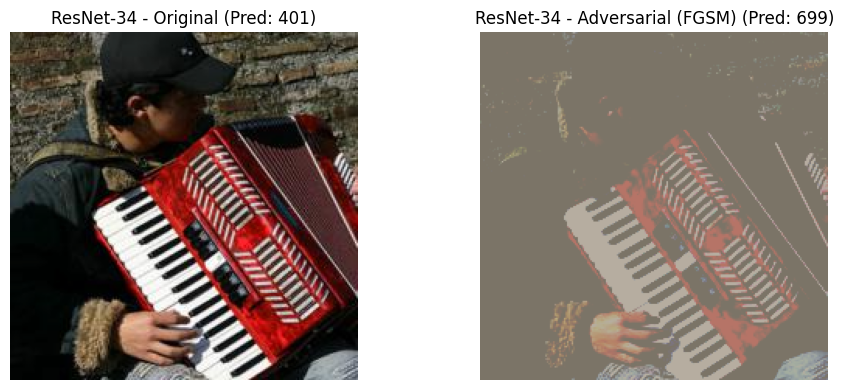

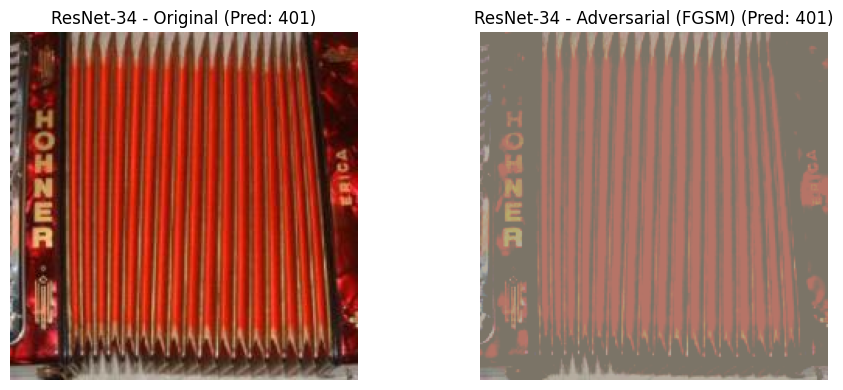

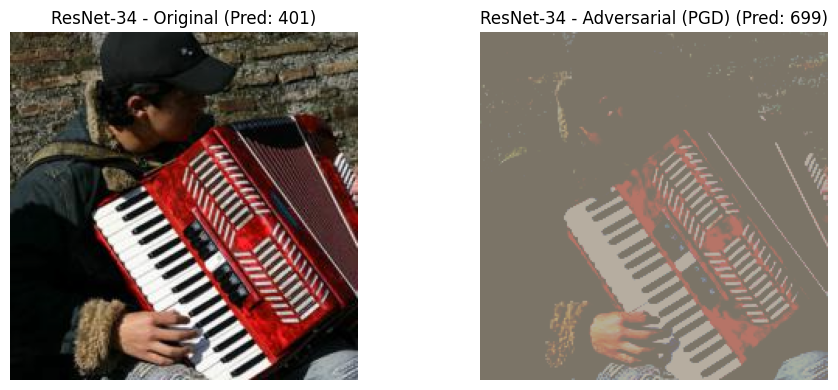

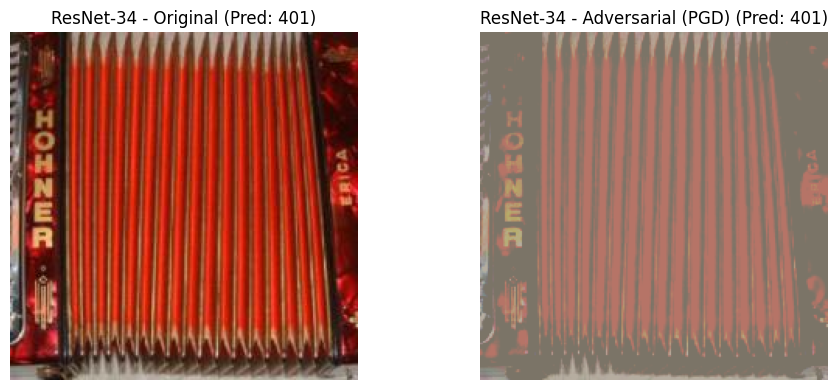

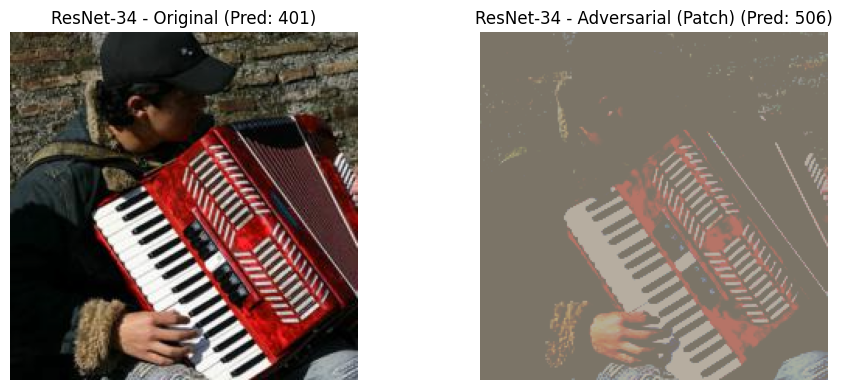

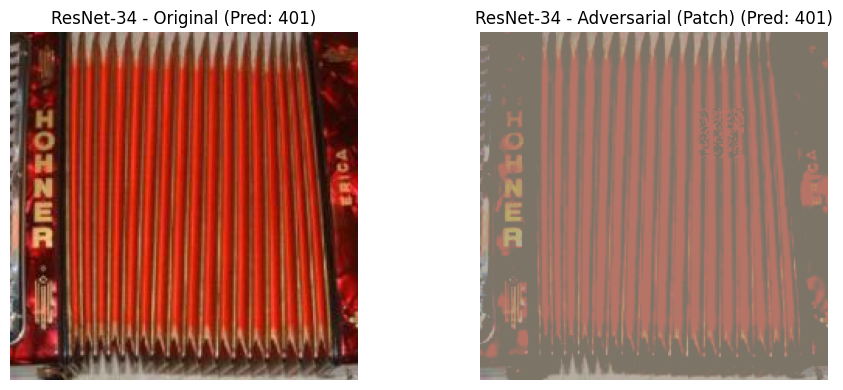


[Visualizations for DenseNet-121]


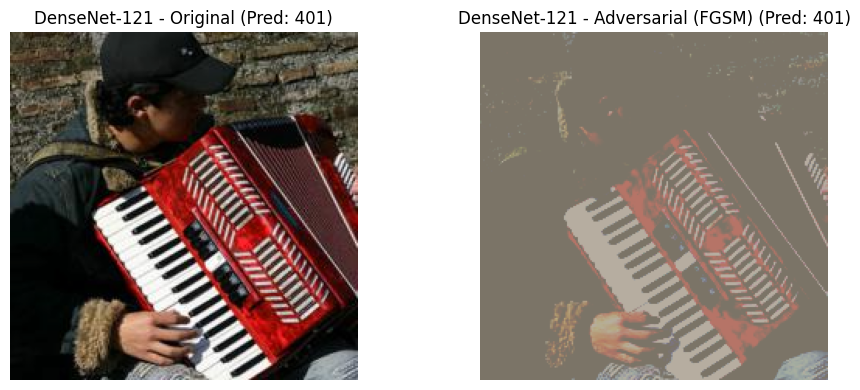

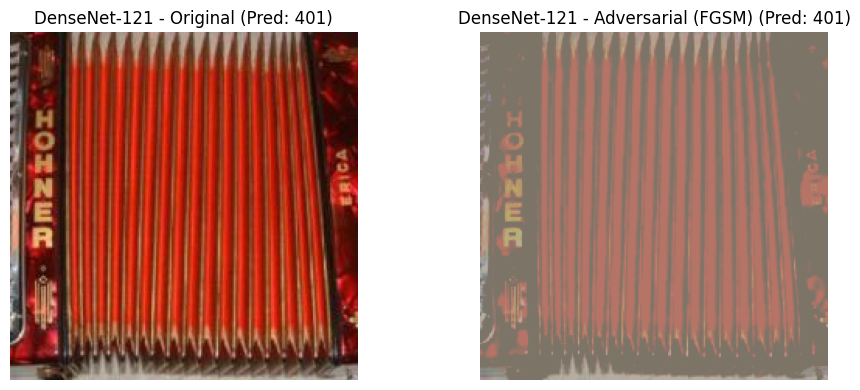

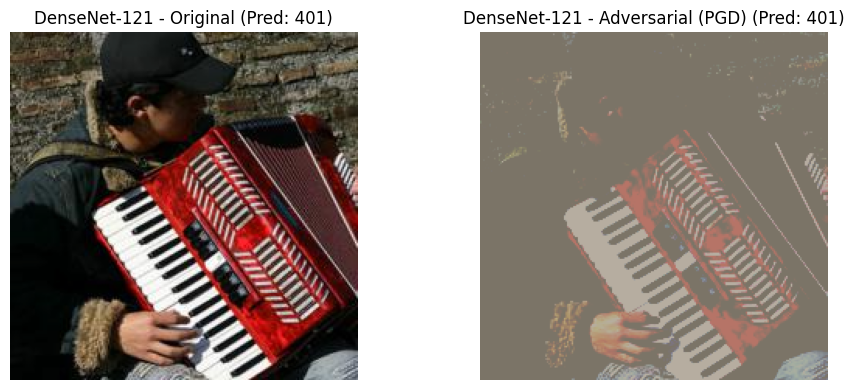

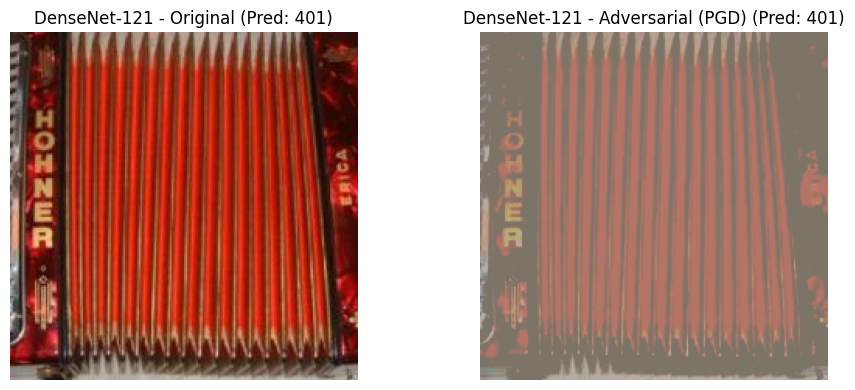

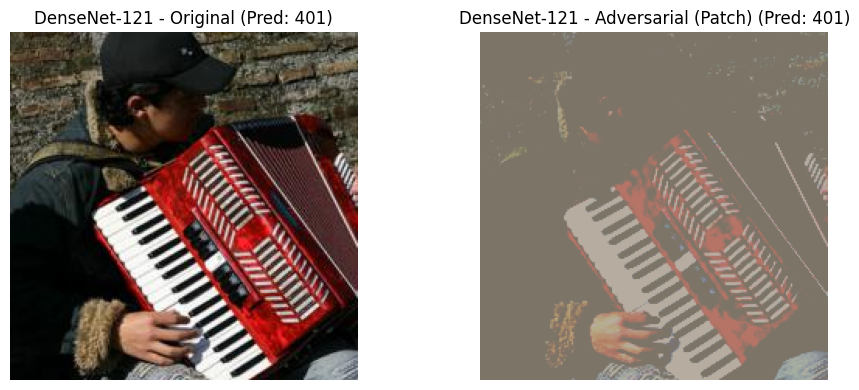

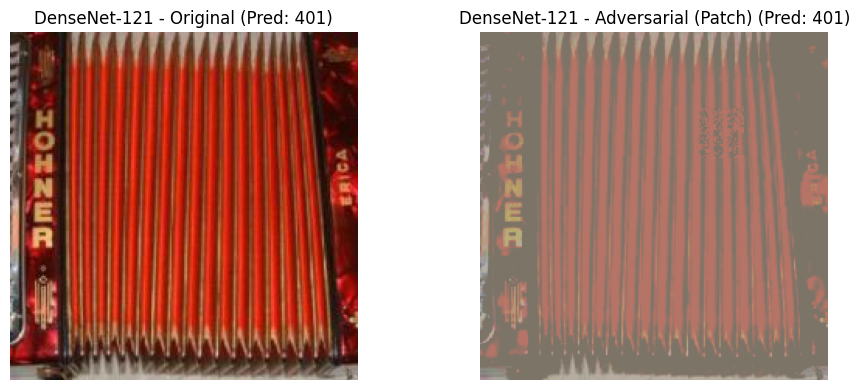

In [18]:
# Denormalization transform
def tensor_to_image(tensor):
    tensor = tensor.cpu().clone()
    tensor = tensor.squeeze(0) if tensor.dim() == 4 else tensor  # remove batch dim if present
    tensor = tensor.permute(1, 2, 0)  # CxHxW -> HxWxC
    tensor = tensor * torch.tensor(std_norms) + torch.tensor(mean_norms)  # denormalize
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.numpy()

# Prediction label helper
def get_pred_label(model, image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(image_tensor)
        _, pred = output.max(1)
    return pred.item()

# Plot original vs adversarial images with predicted labels
def plot_comparison(orig, adv, idx, attack_name, model, model_name):
    orig_img = tensor_to_image(orig[idx])
    adv_img = tensor_to_image(adv[idx])

    orig_pred = get_pred_label(model, orig[idx])
    adv_pred = get_pred_label(model, adv[idx])

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(orig_img)
    ax[0].set_title(f"{model_name} - Original (Pred: {orig_pred})")
    ax[0].axis('off')

    ax[1].imshow(adv_img)
    ax[1].set_title(f"{model_name} - Adversarial ({attack_name}) (Pred: {adv_pred})")
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

# Helper to visualize examples
def visualize_examples(orig_dataset, adv_dataset, attack_name, model, model_name):
    for i in range(2):
        plot_comparison(orig_dataset, adv_dataset, i, attack_name, model, model_name)

# Load a small batch of original images from the dataloader
original_images_batch, _ = original_images_batch, _ = next(iter(dataloader))
original_images_batch = original_images_batch.cpu()

# ============================
# Visualize for ResNet-34
# ============================
print("\n[Visualizations for ResNet-34]")
visualize_examples(original_images_batch, adv_set_1, "FGSM", model, "ResNet-34")
visualize_examples(original_images_batch, adv_set_2, "PGD", model, "ResNet-34")
visualize_examples(original_images_batch, adv_set_3, "Patch", model, "ResNet-34")

# ============================
# Visualize for DenseNet-121
# ============================
print("\n[Visualizations for DenseNet-121]")
visualize_examples(original_images_batch, adv_set_1, "FGSM", densenet_model, "DenseNet-121")
visualize_examples(original_images_batch, adv_set_2, "PGD", densenet_model, "DenseNet-121")
visualize_examples(original_images_batch, adv_set_3, "Patch", densenet_model, "DenseNet-121")
